# Searching for transient and variable sources
## Author: Antonia Rowlinson

This Jupyter Notebook is for use with the new TraP (2025) and demonstrates the current best practice for searching for transients and variable sources in the output from the LOFAR Transients Pipeline, TraP (Swinbank et al. 2015). 

TraP is a publicly available pipeline with the following resources:
- [Code](https://git.astron.nl/RD/trap)
- [Documentation](https://transients-pipeline.readthedocs.io/en/latest/)
- [Publication](https://ui.adsabs.harvard.edu/abs/2015A%26C....11...25S/abstract)
- [Original Demo](https://github.com/AntoniaR/TraP_filter_demo)

TraP is now also pip installable with this command:
```pip install trap```

The standalone source finder is PySE which is pip installable with:
```pip install radio-pyse```

PySE is a publicly available pipeline with the following resources:
- [Code](https://github.com/transientskp/pyse)
- [Documentation](https://pyse.readthedocs.io/en/stable/)
- [Publication](https://scixplorer.org/abs/2018A&C....23...92C/abstract)

The methods presented in this Jupyter Notebook are the culmination of years working with the TraP outputs. 

**CAVEATS:** 
- These methods may not catch everything interesting/unusual in the TraP databases! We are still refining search techniques to find out more.
- Get to know your data to confirm these 'standard' settings work for you! I recommend studying a small percentage of large datasets to get a feel for what type of filtering and processing strategy works best for you.
- This Jupyter Notebook will be slow for very large datasets. Split it into smaller processes or standalone scripts.

### Quality Control: Pre-TraP Assessment

Quality control of your data is essential for ensuring that you minimise the number of false positive detections. We have found that the simplest and most optimal method for datasets checked to date is implementing an rms noise clip on your images. This clipping can be conducted in TraP, but you need to determine what the optimal settings are for your data. n.b. there is an automated version in TraP, but it is currently very slow and I recommend you do not use it.

The code below will load all images in the path and calculate the rms noise in the inner part of your image. This is the identical method to that used in TraP to determine the rms noise in the images. The TraP also conducts a check on the restoring beam shape and for nearby bright sources.

This code is based upon the PreTraPimageQC code in [TraP_tools](https://github.com/transientskp/TraP_tools/tree/master).

**CAVEATS** 
- This part assumes you only have 1 observing frequency. See the full code for how to handle multiple frequency datasets.
- The version below fits the rms noise in linear space whereas in the full code we used log space. Further investigation required to determine if linear space is sufficient.
- For very large datasets, this gets very slow. I recommend using a representative subset, e.g. 10%, to characterise what a good image should look like and then apply the thresholds to your full dataset in TraP. Conducting a random sample of your images is now implemented in this code.

In [1]:
import sys
import os
import astropy.io.fits as pyfits
import numpy as np
import glob
import pandas as pd
from matplotlib import pyplot as plt 
import random
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy.io import fits
from astropy.stats import sigma_clip


In [2]:
import getRMS  
# This is a script that is in the github repository associated with this code. 
# It will calculate a sigma clipped rms in the inner region of the images being processed.
# The clipping factor and relative size of the image to be considered can be input as parameters.

In [3]:
nBins = 500 
# the number of bins to be used in the rms analysis

In [4]:
randomPercentage = 1 #0.01
# This is the percentage of the data you want to use for the quality control steps

In [5]:
sigmaClip = 3 # This is the sigma clip used to remove sources from the rms calculation. 
# Usually 3 is used in TraP (see rms_est_sigma in the job_config)

In [6]:
f = 8 # This is the fraction of the image that will be used for the rms calculation.
# Usually 8 is used in TraP.

#### Method needs updating to match new TraP parameter

In [7]:
sigmaRej = 3 # This is the rejection sigma for bad images.
# If the image is deviant from the mean by more than this value (positive or negative) the image is rejected.

In [8]:
path_to_images = '/archive/TraP_test_data/MeerKAT_J1820/mfs/'

Read all the images and measure the rms noise in the central region. Store as a Pandas dataframe.

In [9]:
imageList = glob.glob(path_to_images+'*.fits')
numImages = len(imageList)
randomImages = random.sample(imageList,int(randomPercentage*numImages))
print(len(randomImages))
numImages

65


65

In [10]:
if os.path.exists('J1820_image_rms.csv'):
    imageData = pd.read_csv('J1820_image_rms.csv')
else:
    imageData=[]
    ### code idea - this could be paralellised to increase speed
    for filename in randomImages:
        data = getRMS.read_data(pyfits.open(filename)[0],filename, plane=None)
        imageData.append([filename, getRMS.rms_with_clipped_subregion(data, sigmaClip, f)*1000.])

    imageData = pd.DataFrame(imageData, columns=['filename','rms'])
    imageData.to_csv('J1820_image_rms.csv')
#imageData

Fit a histogram to the rms noise values. n.b. sometimes you have to tweak the number of bins (here and in the boxes 19 & 20) to get the Gaussian fitting working sufficiently well for your data.

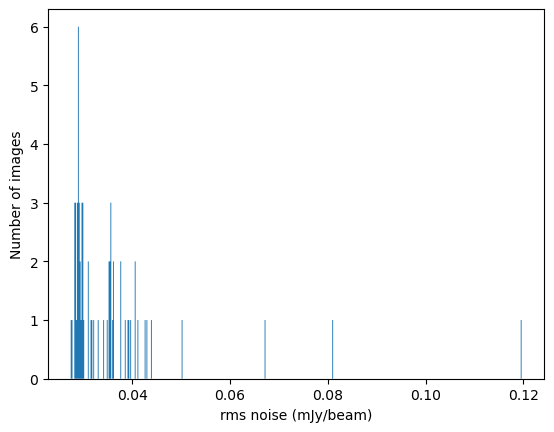

In [11]:
plt.hist(imageData.rms,bins=nBins,histtype='stepfilled')

plt.xlabel('rms noise (mJy/beam)')
plt.ylabel('Number of images')

plt.show()

Drop images that have NaN as their rms value and those with extreme rms values. And remove from the Random Sample for later processing steps.

In [12]:
#imageData = imageData.dropna()
#newlist = imageData.filename.tolist()
#randomImages=[x for x in randomImages if x in newlist]

#mean=np.mean(imageData.rms)
#median=np.median(imageData.rms)
#stdev = np.std(imageData.rms)
#print(mean,median,stdev)

#rmsVals = imageData.rms
#rmsVals = sigma_clip(rmsVals, sigma=6, maxiters=5, cenfunc='median', masked=False) # clip out the sources
        
#imageData = imageData[imageData.rms < np.max(rmsVals)]

#plt.hist(imageData.rms,bins=nBins,histtype='stepfilled')

#plt.xlabel('rms noise (mJy/beam)')
#plt.ylabel('Number of images')

#plt.show()

In [13]:
# functions to fit a Gaussian distribution to data

def res(p, y, x):
# calculate residuals between data and Gaussian model
  m1, sd1, a = p
  y_fit = a*norm2(x, m1, sd1)
  err = y - y_fit
  return err

def guess_p(x):
# estimate the mean and rms as initial inputs to the Gaussian fitting
    median = np.median(x)
    temp=[n*n-(median*median) for n in x]
    rms = math.sqrt((abs(sum(temp))/len(x)))
    return [median, rms, math.sqrt(len(x))]

def norm2(x, mean, sd):
# creates a normal distribution in a simple array for plotting
    normdist = []
    for i in range(len(x)):
        normdist += [1.0/(sd*np.sqrt(2*np.pi))*np.exp(-(x[i] - mean)**2/(2*sd**2))]
    return np.array(normdist)

In [14]:
from scipy.optimize import leastsq
import math

# Obtain the data in a binned histogram for fitting
hist_rms=np.histogram(imageData.rms,bins=nBins)
range_x=[hist_rms[1][n]+(hist_rms[1][n+1]-hist_rms[1][n])/2. for n in range(len(hist_rms[1])-1)]

# Guess the mean and standard deviation based upon the median value
p = guess_p(imageData.rms)
print(p)

# Calculate the best fitting Gaussian distribution
plsq = leastsq(res, p, args = (hist_rms[0], range_x)) # fit Gaussian to data
fit2 = plsq[0][2]*norm2(range_x, plsq[0][0], plsq[0][1]) # create Gaussian distribution for plotting on graph

[np.float64(0.0310878433049848), 0.022155284995196485, 8.06225774829855]


/tmp/ipykernel_3560172/2752860679.py:13: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  plsq = leastsq(res, p, args = (hist_rms[0], range_x)) # fit Gaussian to data


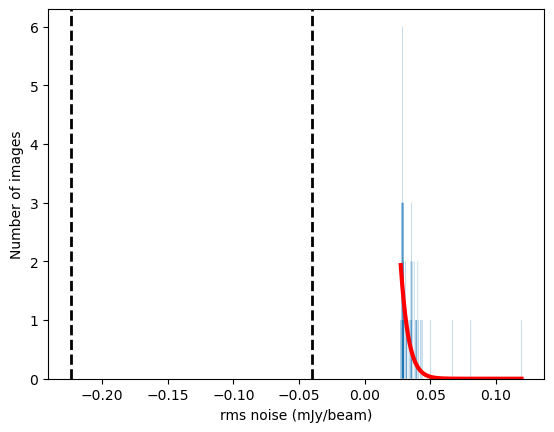

In [15]:
# Create a plot of the results

plt.plot(range_x,fit2, 'r-', linewidth=3)
plt.hist(imageData.rms,bins=nBins,histtype='stepfilled')

sigcut=plsq[0][0]+plsq[0][1]*sigmaRej # max threshold defined as (mean + RMS * sigma)
sigcut2=plsq[0][0]-plsq[0][1]*sigmaRej # min threshold defined as (mean - RMS * sigma)
plt.axvline(x=sigcut, linewidth=2, color='k',linestyle='--')
plt.axvline(x=sigcut2, linewidth=2, color='k', linestyle='--')

plt.xlabel('rms noise (mJy/beam)')
plt.ylabel('Number of images')

plt.savefig('deep_rms_plot.png', dpi=1200)
plt.show()

In [16]:
# Thresholds for TraP job parameters file (job_params.cfg):
rms_est_max=sigcut/1e3
rms_est_min=sigcut2/1e3
print('rms_est_max = '+ str(rms_est_max))
print('rms_est_min = '+ str(rms_est_min))

rms_est_max = -3.9811119292287646e-05
rms_est_min = -0.00022409897046065186


Remove the rejected images from the random sample of images for the next tests.

In [17]:
imageData = imageData[(imageData.rms < rms_est_max*1e3) & (imageData.rms > rms_est_min*1e3)]
newlist = imageData.filename.tolist()
randomImages=[x for x in randomImages if x in newlist]
#print(imageData)

### Choosing an appropriate systematic position offset

The position uncertainties output by the transients pipeline are only measurement errors and do not account for systematic position uncertainties caused by e.g. the ionosphere.

Setting this systematic position offset to be too high will lead to bad source associations and not including it means that bright sources may not be correctly associated.

Here we use a random sample of images in the dataset to quantify the typical position offset in snapshot images versus the source position in a deep image of the field. We use a simple source association procedure from astropy.


In [18]:
deepImage = '/archive/TraP_test_data/MeerKAT_J1820/mfs/img_1584171959_sdp_l0_1024ch_MAXIJ1820.ms_pcalmask-MFS-image.pbcor.fits'
detectThresh = 10.
detectThreshDeep = 10.
radius = 1200 # pixels equivalent to 2.5 degrees
radiusDeep = 1200 #3600
grid = 50 # pixels
deblend = 0 # 0 = turned off
forceBeam = True
maxSep = 20  # arcsec
minSNR = 20 # use a large value to ensure that you are only using the brightest sources to estimate the uncertainty

Run the source finder, PySE, on all the images in the random sample of images to measure the positions of the sources and their uncertainties.

In [19]:
for image in randomImages:
    img = image.split('.fits')[0]+'.csv'
    img = img.split('/')[-1]
    if os.path.isfile(img):
        print(img)
    else:
        if forceBeam:
            #### pyse is now a python module that can be installed, so maybe PySE can be called directly
            print('pyse --detection-th '+str(detectThresh)+' --deblend-mincont '+str(deblend)
                      +' --grid '+str(grid)+' --radius '+ str(radius)+' --force-beam --csv '+image)
            os.system('pyse --detection-th '+str(detectThresh)+' --deblend-mincont '+str(deblend)
                      +' --grid '+str(grid)+' --radius '+ str(radius)+' --force-beam --csv '+image)
        else:
            os.system('pyse --detection-th '+str(detectThresh)+' --deblend-mincont '+str(deblend)
                      +' --grid '+str(grid)+' --radius --force-beam --csv'+ str(radius)+image)

Run PySE on the deep image to get the main source catalogue. Use 20 sigma detection threshold so only brighter sources. Otherwise the same PySE settings.

In [20]:
img = deepImage.rstrip('.fits')+'.csv'
img = img.split('/')[-1]
if os.path.isfile(img):
    runcat =pd.read_csv(img, delimiter=', ', engine='python')
else:       
    if forceBeam:
        os.system('pyse --detection-th '+str(detectThreshDeep)+' --deblend-mincont '+str(deblend)
                    +' --grid '+str(grid)+' --radius '+ str(radiusDeep)+' --force-beam --csv '+deepImage)
    else:
        os.system('pyse --detection-th '+str(detectThreshDeep)+' --deblend_mincont --csv '+str(deblend)
                    +' --grid '+str(grid)+' --radius '+ str(radiusDeep)+deepImage)
    runcat =pd.read_csv(img, delimiter=', ', engine='python')
#print(runcat.columns.tolist())
runcat['SkyCoords'] = runcat.apply(lambda row: coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5'), axis=1)
#print(runcat)
rct = coord.SkyCoord(runcat.ra, runcat.dec, unit=(u.deg, u.deg), frame='fk5')

Loop through all the images to determine the offset from the deep image position. Use astropy source association

In [21]:
if os.path.exists('J1820_deep_seps.csv'):
    AllSeps = pd.read_csv('J1820_deep_seps.csv')
else:
    AllSeps = pd.DataFrame(columns = ['img','ra_err','dec_err','sep','snr'])
    for image in randomImages:
        #### Maybe this can be parallelised?
        img = image.split('.fits')[0]+'.csv'
        img = img.split('/')[-1]
        sources = pd.read_csv(img, delimiter=', ', engine='python')
        sources['SkyCoords'] = sources.apply(lambda row: coord.SkyCoord(row.ra, row.dec, unit=(u.deg, u.deg), frame='fk5'), axis=1)
        srcs = coord.SkyCoord(sources.ra, sources.dec, unit=(u.deg, u.deg), frame='fk5')
        idx, d2d, d3d = srcs.match_to_catalog_sky(rct)
        seps = np.array(d2d.arcsecond)     
        sources['sep']=seps
        sources['img']=img
        sources = sources.filter(['img','ra_err','dec_err','sep','snr'])
        AllSeps = pd.concat([AllSeps, sources])
        ### pd.concat is depriciated for empty dataframes, so this needs checking/fixing
    
    AllSeps.to_csv('J1820_deep_seps.csv')

Conduct selections on the data to reject bad associations (using maxSep) and to focus on only the high SNR sources

In [22]:
AllSeps = AllSeps[AllSeps.sep < maxSep]
AllSeps = AllSeps[AllSeps.snr > minSNR]


The offsets being measured should be a combination of the fitting error and the systematic error. These are normally added in quadrature. i.e. offset = sqrt ( ra_error^2 + dec_error^2 + systematic^2) --> offset^2 / (ra_error^2 + dec_error^2 ) = systematic^2
We use the median values so as not to be biased towards larger offsets.


nan


/home/antoniar/miniconda3/envs/timo_trap2/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/antoniar/miniconda3/envs/timo_trap2/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
/tmp/ipykernel_3560172/2856352014.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


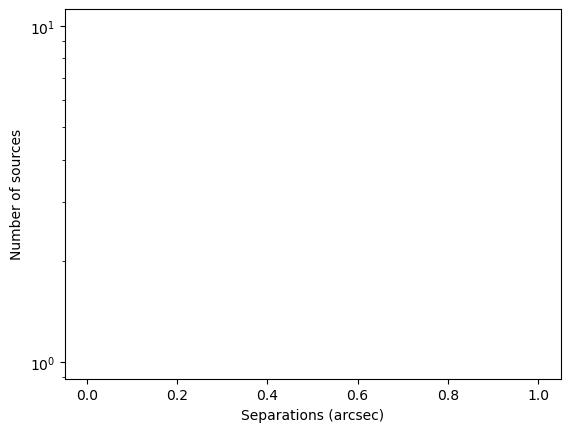

In [23]:
systematic = np.median(AllSeps.sep)**2. / (np.median(3600*AllSeps.ra_err)**2. + np.median(3600*AllSeps.dec_err)**2.)
print(systematic**0.5)


# Create a plot of the results
plt.hist(AllSeps.sep,bins=nBins,histtype='stepfilled')
plt.axvline(x=systematic**0.5, linewidth=2, color='k',linestyle='--')

plt.xlabel('Separations (arcsec)')
plt.ylabel('Number of sources')
plt.yscale('log')

plt.savefig('deep_separations_plot.png', dpi=1200)
plt.show()

### Running the TraP

The next step in the process is running the TraP on your data. You need to set up the TraP according to the instructions and initiate a job.


Possible code improvement - TraP is now a python module so in theory could be called and run directly.

In [24]:
tomlName = "ELAIS-N1_trap.toml"
dbName = "ELAIS_deep_db_6000pix"
#path=os.getcwd()
path='/scratch/antoniar/Timo_TraP_tests/ELAIS_snapshots2/'

In [ ]:

#text_file = open(tomlName, "w")

#text_file.write('''
## This file defines the parameters to use for TraP processing
## These parameters can be overwritten by environment variables
## or command line arguments where command line arguments are
## considered first, then environment variables and lastly the
## parameters set in this file.

## For an explenation of each of the parameters, run `trap-run --help` or refer to
## the documentation at: https://transients-pipeline.readthedocs.io/en/latest/input_parameters.html

#[general]
#log_dir = "./logs"

#[database]
#db_name = "%s"
#db_backend = "sqlite"
#db_host = "localhost"
#db_port = "5432"
#db_user = "trap_test"
#db_password = "trap_test"
#db_overwrite = false

#[image_quality]
#rms_min = %s
#rms_max = %s
#reduction_factor_for_rms = 20

#[extraction]
#ew_sys_err = %s
#ns_sys_err = %s
#detection_threshold = %s
#analysis_threshold = 3
#deblend_nthresh = %s
#max_nr_consecutive_force_fits = 10
#force_beam = true

#[extraction.image]
#im_margin = 0
#im_radius = %s
#im_back_size_x = 50
#im_back_size_y = 50

#[association]
#de_ruiter_r_max = 5.68

#''' % (dbName, str(rms_est_min), str(rms_est_max), str(systematic), str(systematic), str(detectThresh), str(deblend), str(radius) ))

#text_file.close()


In [ ]:
#os.system("trap-run --config_file "+tomlName+" -i '"+path_to_images+"*.fits' --nr_threads 4")
#print('finished!')

In [25]:
import trap

import sqlalchemy
dbEngine=sqlalchemy.create_engine('sqlite:////scratch/antoniar/Timo_TraP_tests/ELAIS_snapshots2/ELAIS_deep_db_6000pix')
connection = dbEngine.connect()

#pd.read_sql('select * from images',dbEngine)


In [26]:
dataset_id="ELAIS_deep_6000pix"

Show the schema of the database

In [28]:
from sqlalchemy import inspect

inspector = inspect(dbEngine)
schemas = inspector.get_schema_names()

for schema in schemas:
    print("schema: %s" % schema)
    for table_name in inspector.get_table_names(schema=schema):
        print(table_name)
        for column in inspector.get_columns(table_name, schema=schema):
            print("Column: %s" % column)

schema: main
config
Column: {'name': 'version', 'type': BOOLEAN(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'pyse_version', 'type': BOOLEAN(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'config_file', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'log_dir', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'nr_threads', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'scheduler', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'db_backend', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'db_name', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'db_host', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
Column: {'name': 'db_port', 'type': TEXT(), 'nullable': True, 'default': None, 'pr

### Variability Searches


Much of the work in this section is based upon the methods and codes presented in [Rowlinson et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26C....27..111R/abstract) and [Valdata et al. (in prep)]()

TraP measures two variability parameters (see [Swinbank et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015A%26C....11...25S/abstract)):
 - **the reduced weighted &chi;^2 (&eta;)** : This is from a fit to the light curve assuming that the flux density of your source is constant. The larger this value, the less well it fits to a horizontal line and thus the more variable the source is.
 - **the coefficient of variation (V)** : This measures the magnitude of the flux density variation in the light curve. The larger this value, the larger the variation in the flux density measurements and thus the more variable the source is.

For reference, TraP measures this value for every single time step in the light curve. Typically (and in the following code), we just use the value associated with the last data point in the light curve when assessing the variability of sources.

Much of the following code is based on the FilterVariables.py code in [TraP_tools](https://github.com/transientskp/TraP_tools/tree/master).

First, let's get the variability parameters for all the sources in the dataset. We do this by querying the Varmetric and Runningcatalog tables in the TraP database. So first, import the tools required for those tables and then obtain the data from the database.

In [31]:
# Using Timo's tools to get the varmetric table

db_path = "/scratch/antoniar/Timo_TraP_tests/ELAIS_snapshots2/ELAIS_deep_db_6000pix"
db_handle = trap.io.open_db("sqlite", db_path)
from trap.post_processing import construct_varmetric
varmetric_table = construct_varmetric(db_handle)

pd.set_option("display.max_rows", None, "display.max_columns", None)
varmetric_table

2026-01-23 11:16:58,757 - TraP - INFO - Establishing sqlite database connection for '/scratch/antoniar/Timo_TraP_tests/ELAIS_snapshots2/ELAIS_deep_db_6000pix' (io.py:296)


newsource     v_int       eta_int  lightcurve_max  lightcurve_avg  \
0             0  0.493591      7.025745        0.001540        0.000553   
1             1       NaN           NaN        0.000286        0.000286   
2             2       NaN           NaN        0.000313        0.000313   
3             3  0.342490      4.857740        0.000748        0.000550   
4             4  0.140504      2.570263        0.006415        0.004427   
5             5  0.075949    102.473788        0.194806        0.167826   
6             6  0.102648      6.614510        0.019403        0.015522   
7             7  0.089637      4.328946        0.013365        0.011611   
8             8  0.196935      1.456561        0.002356        0.001908   
9             9  0.032225      0.035123        0.001529        0.001495   
10           10  0.091131      0.581231        0.003234        0.002548   
11           11  0.156892      1.335958        0.002627        0.002004   
12           12  0.091924      0.291159        0.001972        0.001566   
13           13  0.069465      0.422532        0.003619        0.003125   
14           14  0.115427      0.881790        0.006627        0.005140   
15           15  0.107192      1.253368        0.004112        0.003363   
16           16  0.343315      2.399074        0.004715        0.001511   
17           17  0.065950      1.273956        0.007872        0.006995   
18           18  0.047758     23.200783        0.300213        0.273751   
19           19  0.092961      0.388794        0.002209        0.001885   
20           20  0.117368      0.685613        0.002266        0.001846   
21           21  0.073261      0.433990        0.003206        0.002636   
22           22  0.089541      0.343687        0.001939        0.001662   
23           23  0.103856      0.400962        0.002051        0.001557   
24           24  0.082372      0.449291        0.002569        0.002252   
25           25  0.088992      0.306290        0.002050        0.001706   
26           26  0.075288      1.272746        0.007638        0.006342   
27           27  0.106087      0.424132        0.001725        0.001464   
28           28  0.079440      3.385837        0.011797        0.010598   
29           29  0.067230      1.843757        0.010306        0.008618   
30           30  0.084425      0.316505        0.002186        0.001777   
31           31  0.096168      0.493850        0.002605        0.002197   
32           32  0.134615      2.138275        0.004544        0.003445   
33           33  0.091271      0.318956        0.001766        0.001470   
34           34  0.119465      4.210567        0.009312        0.007228   
35           35  0.093917      0.488397        0.002330        0.001903   
36           36  0.137036      0.810117        0.001941        0.001615   
37           37  0.105177      0.465658        0.002723        0.001964   
38           38  0.092041      0.334627        0.001562        0.001430   
39           39  0.093227      0.425698        0.001854        0.001649   
40           40  0.135891      0.926257        0.002688        0.001872   
41           41  0.063331      0.143205        0.001567        0.001420   
42           42  0.048660      0.083095        0.001321        0.001254   
43           43  0.070483      0.382992        0.002750        0.002413   
44           44  0.113526     10.629824        0.020611        0.015770   
45           45  0.140639     98.995276        0.107540        0.084167   
46           46  0.096888      0.353131        0.002082        0.001585   
47           47  0.106379      0.584993        0.002391        0.001939   
48           48  0.180847      1.051574        0.002159        0.001539   
49           49  0.102649      0.717398        0.003093        0.002501   
50           50  0.115367      0.755548        0.002475        0.001878   
51           51  0.118969      0.651065        0.002192        0.001738   
52           52  0.097119      

In [32]:
from datetime import datetime
from datetime import timezone

varmetric_table['first_detect_time'] = varmetric_table.apply(lambda row: datetime.strptime(row.first_detection_time, '%Y-%m-%d %H:%M:%S.%f').replace(tzinfo=timezone.utc), axis=1)

For simplicity, we ignore all sources that are identified as new sources. These are sources that were not identified in the first image and may be transients. The candidate transients are filtered using a different strategy (see section on Transient Searches). For this we then use all sources with the maximum number of datapoints

We also reject any remaining sources that have "NaN" for one of their variability parameters as these only have 1 datapoint.

In [33]:
varmetric_table = varmetric_table[varmetric_table['v_int'].notna()]
varmetric_table = varmetric_table[varmetric_table['eta_int'].notna()]
varmetric_table = varmetric_table[varmetric_table['lightcurve_max'].notna()]
maxDpts = max(varmetric_table['nr_datapoints'].to_list())
varmetric_table = varmetric_table.loc[varmetric_table['nr_datapoints']==maxDpts]
#varmetric_table = varmetric_table.loc[varmetric_table['nr_datapoints']>2]
varmetric_table

newsource     v_int      eta_int  lightcurve_max  lightcurve_avg  \
4             4  0.140504     2.570263        0.006415        0.004427   
5             5  0.075949   102.473788        0.194806        0.167826   
6             6  0.102648     6.614510        0.019403        0.015522   
7             7  0.089637     4.328946        0.013365        0.011611   
10           10  0.091131     0.581231        0.003234        0.002548   
13           13  0.069465     0.422532        0.003619        0.003125   
15           15  0.107192     1.253368        0.004112        0.003363   
16           16  0.343315     2.399074        0.004715        0.001511   
17           17  0.065950     1.273956        0.007872        0.006995   
18           18  0.047758    23.200783        0.300213        0.273751   
21           21  0.073261     0.433990        0.003206        0.002636   
24           24  0.082372     0.449291        0.002569        0.002252   
26           26  0.075288     1.272746        0.007638        0.006342   
28           28  0.079440     3.385837        0.011797        0.010598   
29           29  0.067230     1.843757        0.010306        0.008618   
32           32  0.134615     2.138275        0.004544        0.003445   
34           34  0.119465     4.210567        0.009312        0.007228   
43           43  0.070483     0.382992        0.002750        0.002413   
44           44  0.113526    10.629824        0.020611        0.015770   
49           49  0.102649     0.717398        0.003093        0.002501   
53           53  0.172464   204.653082        0.124017        0.094908   
54           54  0.087502     8.882196        0.017853        0.015518   
56           56  0.124937     0.783176        0.002461        0.001970   
58           58  0.061213     0.949183        0.007044        0.006234   
60           60  0.118918     3.220346        0.006691        0.005437   
61           61  0.106271     0.904366        0.002618        0.002241   
63           63  0.087760     0.591458        0.003414        0.002619   
67           67  0.058071     0.757411        0.006442        0.005721   
68           68  0.090392     0.457535        0.002364        0.001985   
69           69  0.066978     1.671353        0.008425        0.007517   
75           75  0.202107     0.671362        0.002007        0.001052   
77           77  0.084718     2.424758        0.009007        0.007677   
79           79  0.059248    29.164019        0.095160        0.086064   
84           84  0.075649     6.086846        0.023372        0.019647   
85           85  0.070457     0.636757        0.003804        0.003319   
87           87  0.086206     1.204590        0.005647        0.004696   
88           88  0.081039     1.345211        0.005389        0.004538   
89           89  0.065910     0.873593        0.005424        0.004775   
92           92  0.097885     0.561540        0.002639        0.002158   
93           93  0.076954    13.023449        0.040022        0.034384   
94           94  0.056245     0.991333        0.006552        0.005896   
95           95  0.068419     2.622314        0.012898        0.010755   
96           96  0.069856     0.474408        0.003230        0.002780   
98           98  0.146072    51.859567        0.060280        0.040659   
100         100  0.094529     1.339782        0.004530        0.003791   
101         101  0.076071     1.164694        0.007471        0.006611   
102         102  0.115586     1.735185        0.005594        0.003920   
103         103  0.209397     9.468534        0.008267        0.005473   
105         105  0.078346     0.562907        0.003256        0.002757   
106         106  0.081604     0.493843        0.002781        0.002315   
107         107  0.054994    10.650453        0.032367        0.029863   
112         112  0.117157     0.660556        0.002903        0.002108   
114         114  0.070017     1.781035        0.014010        0.009939   
115       

Insert method to remove extended sources from the analysis

In [34]:
# Python code to remove extended sources using method developed by Thijn Swinkels (UvA)

#### Plotting the variability parameters

We can now plot the variability parameters for all the sources detected in the first image.

In [35]:
from astropy.stats import bayesian_blocks

def make_bins(x):
    new_bins = bayesian_blocks(x)
    binsx = [new_bins[a] for a in range(len(new_bins)-1) if abs((new_bins[a+1]-new_bins[a])/new_bins[a])>0.05]
    binsx = binsx + [new_bins[-1]]
    return binsx

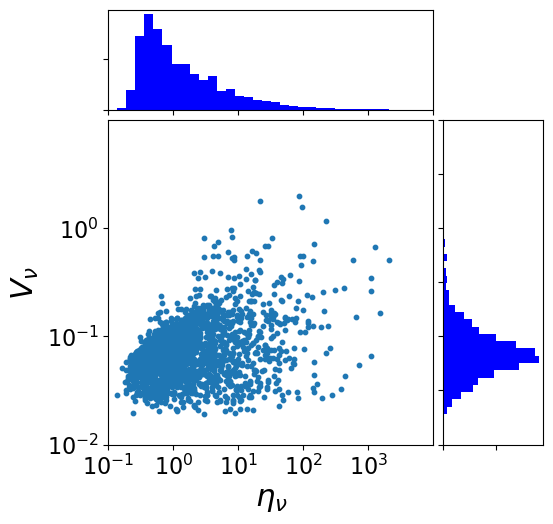

In [36]:
from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties

nullfmt   = NullFormatter()         # no labels
fontP = FontProperties()
fontP.set_size('large')
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left+width+0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]
fig = plt.figure(1,figsize=(5,5))
axScatter = fig.add_subplot(223, position=rect_scatter)
plt.xlabel(r'$\eta_{\nu}$', fontsize=22)
plt.ylabel(r'$V_{\nu}$', fontsize=22)
axHistx=fig.add_subplot(221, position=rect_histx)
axHisty=fig.add_subplot(224, position=rect_histy)
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.axes.yaxis.set_ticklabels([])
axHisty.axes.xaxis.set_ticklabels([])

xdata_var=np.log10(varmetric_table["eta_int"])
ydata_var=np.log10(varmetric_table["v_int"])
axScatter.scatter(xdata_var, ydata_var, s=10.)

x = np.log10(varmetric_table["eta_int"])
y = np.log10(varmetric_table["v_int"])

axHistx.hist(x, bins=30, histtype='stepfilled', color='b')
axHisty.hist(y, bins=30, histtype='stepfilled', orientation='horizontal', color='b')

xmin=int(min(x)-1.1)
xmax=int(max(x)+1.1)
ymin=int(min(y)-1.1)
ymax=int(max(y)+1.1)
xvals=range(xmin,xmax)
xtxts=[r'$10^{'+str(a)+'}$' for a in xvals]
yvals=range(ymin,ymax)
ytxts=[r'$10^{'+str(a)+'}$' for a in yvals]
axScatter.set_xlim([xmin,xmax])
axScatter.set_ylim([ymin,ymax])
axScatter.set_xticks(xvals)
axScatter.set_xticklabels(xtxts, fontsize=16)
axScatter.set_yticks(yvals)
axScatter.set_yticklabels(ytxts, fontsize=16)
axHistx.set_xlim( axScatter.get_xlim())
axHisty.set_ylim( axScatter.get_ylim())

plt.show()

In the simplest case, we now define variable sources as those that are significantly deviant from the population. i.e. we assume that the majority of sources in the radio sky are not variable. From experience, this is a pretty reasonable assumption.

We fit the &eta; and V distributions with a Gaussian curve. Then we can specify the number of &sigma; deviant we want to use as the threshold [(see Rowlinson et al. 2019 for more info)](https://ui.adsabs.harvard.edu/abs/2019A%26C....27..111R/abstract). Typically, 2&sigma; gives a reasonable result.

In [37]:
sigmaThresh = 2

In [38]:
from scipy.stats import norm

def SigmaFit(data):
    median = np.median(data)
    std_median = np.sqrt(np.mean([(i-median)**2. for i in data]))
    tmp_data = [a for a in data if a < 3.*std_median+median and a > median - 3.*std_median]
    param1 = norm.fit(tmp_data)
    param2 = norm.fit(data)
    return param1, param2

In [39]:
paramx, paramx2 = SigmaFit(np.log10(varmetric_table["eta_int"]))
paramy, paramy2 = SigmaFit(np.log10(varmetric_table["v_int"]))

print('Gaussian Fit eta: '+str(round(10.**paramx[0],2))+'(+'+str(round((10.**(paramx[0]+paramx[1])-10.**paramx[0]),2))+' '+str(round((10.**(paramx[0]-paramx[1])-10.**paramx[0]),2))+')')
print('Gaussian Fit V: '+str(round(10.**paramy[0],2))+'(+'+str(round((10.**(paramy[0]+paramy[1])-10.**paramy[0]),2))+' '+str(round((10.**(paramy[0]-paramy[1])-10.**paramy[0]),2))+')')

sigcutx = paramx[1]*sigmaThresh+paramx[0]
sigcuty = paramy[1]*sigmaThresh+paramy[0]

print('eta threshold = '+str(round(10.**sigcutx,2)))
print('V threshold = '+str(round(10.**sigcuty,2)))

Gaussian Fit eta: 1.22(+3.3 -0.89)
Gaussian Fit V: 0.07(+0.04 -0.03)
eta threshold = 16.76
V threshold = 0.18


We can now use these thresholds to identify which sources are variable and illustrate it in the plot.

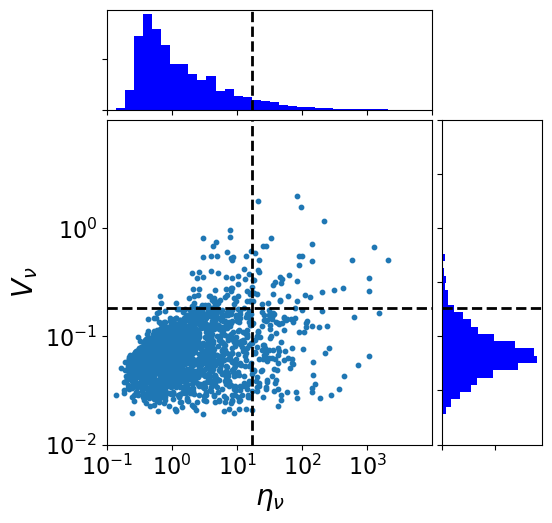

In [40]:

nullfmt   = NullFormatter()         # no labels
fontP = FontProperties()
fontP.set_size('large')
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left+width+0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]
fig = plt.figure(1,figsize=(5,5))
axScatter = fig.add_subplot(223, position=rect_scatter)
plt.xlabel(r'$\eta_{\nu}$', fontsize=20)
plt.ylabel(r'$V_{\nu}$', fontsize=20)
axHistx=fig.add_subplot(221, position=rect_histx)
axHisty=fig.add_subplot(224, position=rect_histy)
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.axes.yaxis.set_ticklabels([])
axHisty.axes.xaxis.set_ticklabels([])
axScatter.scatter(xdata_var, ydata_var, s=10.)

axHistx.hist(x, bins=30, histtype='stepfilled', color='b')
axHisty.hist(y, bins=30, histtype='stepfilled', orientation='horizontal', color='b')

axHistx.axvline(x=sigcutx, linewidth=2, color='k', linestyle='--')
axHisty.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')
axScatter.axhline(y=sigcuty, linewidth=2, color='k', linestyle='--')
axScatter.axvline(x=sigcutx, linewidth=2, color='k', linestyle='--')

xmin=int(min(x)-1.1)
xmax=int(max(x)+1.1)
ymin=int(min(y)-1.1)
ymax=int(max(y)+1.1)
xvals=range(xmin,xmax)
xtxts=[r'$10^{'+str(a)+'}$' for a in xvals]
yvals=range(ymin,ymax)
ytxts=[r'$10^{'+str(a)+'}$' for a in yvals]
axScatter.set_xlim([xmin,xmax])
axScatter.set_ylim([ymin,ymax])
axScatter.set_xticks(xvals)
axScatter.set_xticklabels(xtxts, fontsize=16)
axScatter.set_yticks(yvals)
axScatter.set_yticklabels(ytxts, fontsize=16)
axHistx.set_xlim( axScatter.get_xlim())
axHisty.set_ylim( axScatter.get_ylim())
plt.savefig('EtavsVscatter_newTraP')

plt.show()


In [41]:
variables = varmetric_table.loc[(varmetric_table["eta_int"]>=10.**sigcutx) & (varmetric_table["v_int"]>=10.**sigcuty)]
variables

newsource     v_int      eta_int  lightcurve_max  lightcurve_avg  \
472         472  0.199929    24.066267        0.009807        0.007225   
585         585  0.276394   425.115039        0.052354        0.033585   
610         610  0.253332   201.178784        0.038234        0.028940   
786         786  0.546401    88.440377        0.004244        0.002863   
1287       1287  0.405984    20.853236        0.003128        0.001829   
1375       1375  0.201469    29.378682        0.012604        0.009378   
1759       1759  0.229999   133.852300        0.017586        0.013365   
1834       1834  0.212196    82.634369        0.015717        0.011810   
1848       1848  0.501983   587.749443        0.012433        0.009175   
1883       1883  0.282681    16.893751        0.005394        0.003815   
1925       1925  0.324563    84.650284        0.007367        0.005364   
2043       2043  0.681838    25.235891        0.002506        0.001162   
2143       2143  0.318033    38.915281        0.006501        0.004206   
2192       2192  0.239633   112.324677        0.017039        0.012130   
2263       2263  0.492394   142.649774        0.004788        0.003410   
2270       2270  0.244910    20.505598        0.005172        0.003833   
2291       2291  0.213488    46.153554        0.012917        0.008956   
2394       2394  1.150602   219.229082        0.019377        0.005442   
2507       2507  0.253758    17.103025        0.008812        0.005729   
2530       2530  0.350325    45.055773        0.007340        0.004585   
2558       2558  0.674142    28.130162        0.009082        0.002172   
2592       2592  1.557012    95.691208        0.233371        0.025038   
2678       2678  1.757524    21.265417        0.036531        0.002599   
2808       2808  0.501580  2069.702373        0.027004        0.019875   
2828       2828  0.554785    98.864862        0.003188        0.002130   
2849       2849  0.586168    18.770534        0.001912        0.001142   
2980       2980  0.265947   311.322856        0.043179        0.029534   
3162       3162  0.339664    49.160506        0.005098        0.003823   
3256       3256  0.705796   143.195278        0.006093        0.003295   
3291       3291  0.328131    17.760154        0.007681        0.004715   
3337       3337  0.807107    33.309599        0.024872        0.004392   
3466       3466  0.236706    60.591939        0.011610        0.008066   
3527       3527  0.243105    35.773666        0.007523        0.005549   
3545       3545  0.299642    35.351053        0.008179        0.005458   
3547       3547  1.983527    84.853566        0.100404        0.006339   
3559       3559  0.212027    17.392417        0.010725        0.007697   
3608       3608  0.342676  1076.786538        0.383195        0.165505   
3904       3904  0.670681  1271.278170        0.098908        0.046359   
3999       3999  0.331336    18.287463        0.008659        0.005315   
4030       4030  0.217520    45.696390        0.015443        0.010704   
4110       4110  0.507271    21.335704        0.005206        0.002415   
4115       4115  0.458868    90.518428        0.006473        0.004857   
4190       4190  0.249297    18.328130        0.009209        0.006347   
4243       4243  0.260495  1080.686974        0.034200        0.029925   
4278       4278  0.393895    21.469735        0.003121        0.002261   
4439       4439  0.307701    47.545999        0.010311        0.006632   
4522       4522  0.367927    63.228002        0.014327        0.009297   

      lightcurve_median       wm_ra     wm_dec  av_ra_err  av_dec_err  \
472            0.006986  245.534899  55.664253   0.000049    0.000028   
585            0.034021  245.229257  54.815328   0.000018    0.000010   
610            0.032746  245.259441  55.972707   0.000025    0.000014   
786            0.003725  244.879572  54.522630   0.000135    0.000078   
1287           0.001535  244.200183  54.384911   0.000112    0.000065   
1375           

Obviously, the next step is to plot the light curve to confirm the variability visually. Usually we also want to visually inspect to check for artefacts so we will also load the image. Automating this step is underway for some types of artefacts - such as sidelobes of bright sources.

Assuming the images are still available, we can plot the source and its surroundings. To do this, we need to pull the full light curve for the sources out of the database and we need to access three new tables.

Once you've confirmed the transient candidate is not an artefact, it is useful to determine if there is an associated known source at the location. To do this, we typically query [Simbad](https://simbad.u-strasbg.fr/simbad/) and this can be done automatically within Python.

In [42]:
def extract_data(fits_file_path, ra, dec, size):    
    hdu = fits.open(fits_file_path)[0]
    data1 = hdu.data
    wmap = WCS(hdu.header, naxis=2)
    data1 = data1[0][0]
    return data1, wmap


def fix_axes_limits_ax1(ax1, RA_coord, DEC_coord, wmap,pix_lim):
    """Define a window of 2*pix_lim around the center coordinate in LoTSS."""
    px, py = wmap.wcs_world2pix(RA_coord, DEC_coord, 1)
    ax1.set_xlim(px-pix_lim, px+pix_lim)
    ax1.set_ylim(py-pix_lim, py+pix_lim)

    RA_min, DEC_min = wmap.wcs_pix2world(px-pix_lim, py-pix_lim, 1)
    RA_max, DEC_max = wmap.wcs_pix2world(px+pix_lim, py+pix_lim, 1)

    return px, py, RA_min, DEC_min, RA_max, DEC_max



Get the extracted source table

In [43]:
images = pd.read_sql_query('SELECT * FROM images',connection)
#print(images)

images['start_time'] = images.apply(lambda row: datetime.strptime(row.taustart_ts, '%Y-%m-%d %H:%M:%S.%f').replace(tzinfo=timezone.utc), axis=1)



In [ ]:
from astroquery.simbad import Simbad
import astropy.coordinates as coord

searchRadius = 10. # in arcsec
searchRadius = (searchRadius/3600.)*u.deg


In [ ]:
#print(pd.read_sql_query('SELECT * FROM extracted_sources WHERE src_id=486',connection))

In [ ]:
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.patches import Ellipse

size = 100
maxImgs=[]
for index, row in variables.iterrows():
    sourceID = row.newsource
    print(sourceID)

    result_table = Simbad.query_region(coord.SkyCoord(row.wm_ra, row.wm_dec, unit=(u.deg, u.deg), frame='fk5'), radius=searchRadius)
    srcPos=coord.SkyCoord(row.wm_ra, row.wm_dec, unit=(u.deg, u.deg), frame='fk5')
    if result_table:
        results = [[row['main_id'], row['ra'], row['dec'], srcPos.separation(SkyCoord(str(row['ra'])+' '+str(row['dec']), unit=(u.hourangle, u.deg))).arcsec ] for row in result_table]
        results = pd.DataFrame(results, columns = ['ID','ra','dec','separation'])
        print(results)
    else:
        print('no matches')
    
    lightcurve = pd.read_sql_query('SELECT * FROM extracted_sources WHERE src_id='+str(sourceID),connection)
    #print(lightcurve)
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(121)
    ax1.plot(images.loc[lightcurve.im_id].start_time,lightcurve.peak_flux, color='k')
    for index2, row2 in lightcurve.iterrows():
        if row2.is_force_fit==0:
            ax1.errorbar(images.loc[row2.im_id].start_time,row2.peak_flux, yerr=row2.peak_flux_err, fmt='o', markersize=7, linestyle='-',color='b')
        if row2.is_force_fit==1:
            ax1.errorbar(images.loc[row2.im_id].start_time,row2.peak_flux, yerr=row2.peak_flux_err, fmt='v', markersize=7, linestyle='-',color='r')
    ax1.axhline(y=0.0, color='k', linestyle=':')
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_ylabel('Flux density (Jy)')
    ax1.set_xlabel('Time')
    
    maxFlux = np.max(lightcurve.peak_flux)
    meanFlux = np.mean(lightcurve.peak_flux)
    #print(maxFlux,meanFlux)
    maxFluxImg = lightcurve.loc[lightcurve.peak_flux==maxFlux].im_id.values

    #print(images.loc[maxFluxImg].url.values[0])
    
    extractedData, wcs = extract_data(images.loc[maxFluxImg].url.values[0],row.wm_ra,row.wm_dec,size)
    ax2 = fig.add_subplot(122, projection=wcs)

    print(row.wm_ra,row.wm_dec)
    #print(lightcurve)
    fix_axes_limits_ax1(ax2,row.wm_ra,row.wm_dec, wcs,size)
    ax2.imshow(extractedData, origin='lower', cmap='gray_r', interpolation='nearest',vmin=0,vmax=maxFlux)
    ax2.scatter(row.wm_ra,row.wm_dec,transform=ax2.get_transform('fk5'),facecolor='none', edgecolor='r')
    
    ax2.coords[0].set_format_unit(u.deg)
    ax2.coords[1].set_format_unit(u.deg)
    ax2.set_xlabel('Right Ascension (deg)')
    ax2.set_ylabel('Declination (deg)')
    plt.show()


Write a ds9 regions file

In [ ]:
with open('ds'+str(dataset_id)+'_variable1_regions.reg', 'w') as f:
    f.write('# Region file format: DS9 version 4.1 \n')
    f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
    f.write('fk5 \n')
    for index, row in variables.iterrows():
        f.write('circle('+str(row.wm_ra)+','+str(row.wm_dec)
                    +',10") # text={'+str(row.newsource)+'} \n')
    f.close()


### Variability Searches - version 2

We have noticed that the variability parameters we use show a correlation with the maximum flux density of the source. We show this correlation here:

In [ ]:
fig = plt.figure(figsize=(5, 6))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

axs[0].scatter(varmetric_table['lightcurve_avg'],varmetric_table["eta_int"])
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylabel(r'$\eta$')
axs[1].scatter(varmetric_table['lightcurve_avg'],varmetric_table["v_int"])
axs[1].set_yscale('log')
#axs[1].set_xscale('log')
axs[1].set_ylabel('V')
axs[1].set_xlabel('Average Flux Density (Jy)')
for ax in axs:
    ax.label_outer()

Recent work by [Valdata et al. (in prep)]() takes into account this correlation. It fits the distribution with a linear function and then determines the distances of each data point from the correlation. As we only care about variable sources, we only select the sources that lie above the correlation. We convert to using the log10 values of the variability parameters and flux densities to simplify the code. In the following, we show a simplified version of the code - please refer to the [GitHub repository](https://github.com/ruggerovaldata/Separating-Candidate-Transients/tree/main) for the main code.

In [ ]:
varmetric_table["logEta"] = varmetric_table.apply(lambda row: np.log10(row.eta_int), axis=1)
varmetric_table['logV'] = varmetric_table.apply(lambda row: np.log10(row.v_int), axis=1)
varmetric_table['logFlux'] = varmetric_table.apply(lambda row: np.log10(row.lightcurve_avg), axis=1)

We import the scripts used by Valdata et al. (in prep).

In [ ]:
import myplotting as myplt
import functions as func

In [ ]:
import scipy.optimize as spopt
import scipy.stats as spstat

#freq = plotdata.freq.unique()
#Finding the line that best represents the two parameters of the data
best_params_eta, ml_cfcovar_linear = spopt.curve_fit(func.LinearFit, varmetric_table.logFlux, varmetric_table.logEta)
best_params_V, ml_cfcovar_linear = spopt.curve_fit(func.LinearFit, varmetric_table.logFlux, varmetric_table.logV)

m_eta, q_eta = best_params_eta[0],best_params_eta[1]
m_V, q_V = best_params_V[0],best_params_V[1]
y_eta = func.LinearFit(varmetric_table.logFlux,m_eta,q_eta)
y_V = func.LinearFit(varmetric_table.logFlux,m_V,q_V)

fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)
axs[0].scatter(varmetric_table.logFlux,varmetric_table.logEta)
axs[0].set_ylabel(r'$log_{10}$($\eta$)')
axs[0].plot(varmetric_table.logFlux,y_eta,label='Best fit',color='gray', ls='--')
axs[1].scatter(varmetric_table.logFlux,varmetric_table.logV)
axs[1].set_ylabel(r'$log_{10}$(V)')
axs[1].set_xlabel(r'$log_{10}$(Average Flux Density (Jy))')
axs[1].plot(varmetric_table.logFlux,y_V,label='Best fit',color='gray',ls='--')
for ax in axs:
    ax.label_outer()


Now we extract only the data points that lie above this line.

In [ ]:
#Calculating the paramater distance from the line that has been found earlier
varmetric_table['distsEta'] = varmetric_table.apply(lambda row: func.Params_distance(row.logEta,func.LinearFit(row.logFlux,m_eta,q_eta)), axis=1)
varmetric_table['distsV'] = varmetric_table.apply(lambda row: func.Params_distance(row.logV,func.LinearFit(row.logFlux,m_V,q_V)), axis=1)

dataBest = varmetric_table.loc[(varmetric_table['distsEta'] > 0) & (varmetric_table['distsV'] > 0)]

Now plot the distances from the two lines and fit a multivariate normal distribution to the data. We can then use this fit to determine which sources are outliers to the distribution.

In [ ]:
p = 0.99 #Inserting here the percentage with which the source should be classified as inlier

data_graph = np.vstack([dataBest.distsEta,dataBest.distsV])
data_graph = data_graph.T

mean_deta = np.mean(dataBest.distsEta)
mean_dV = np.mean(dataBest.distsV)
mu = [mean_deta,mean_dV]

cov_matrix = np.cov(dataBest.distsEta,dataBest.distsV)
likelihood = spstat.multivariate_normal.pdf(data_graph,[mean_deta,mean_dV],cov_matrix)

outliers_prob = func.Probability(data_graph,mu,cov_matrix) #Calculating the probability for every parameter of being associated to an "inlier" source

dataBest['probability'] = 100.-outliers_prob
temp = dataBest.sort_values('probability')
dataBest.to_csv('WholedatasetoutputBest.csv', index=False)

figure, axes = myplt.MyCorner(dataBest.distsEta,dataBest.distsV,dataBest.probability/100.,'CornerPlotBest') #Printing the corner plot both with the likelihood and without the likelihood

chi2 = spstat.chi2.ppf([p],2)[0]

# finding the outliers with probabilities >99% and with positive distances abovve the trend line
inliersBest = dataBest.loc[ (dataBest['probability'] <= p*100.) ]
outliersBest = dataBest.loc[ (dataBest['probability'] > p*100.) ]


In [ ]:
# Plotting
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(14,14))

ax1.scatter(outliersBest.logFlux,outliersBest.logEta,color='red',label='Outliers')
ax1.scatter(inliersBest.logFlux,inliersBest.logEta,color='blue',label='Inliers')
ax2.scatter(outliersBest.logFlux,outliersBest.logV,color='red',label='Outliers')
ax2.scatter(inliersBest.logFlux,inliersBest.logV,color='blue',label = 'Inliers')

ax1.set_ylabel(r'$log_{10}(\eta_{\nu}$)',fontsize=30)
ax2.legend(fontsize=15,markerscale=1.5)
ax1.legend(fontsize=15,markerscale=1.5)
ax2.set_ylabel(r'$log_{10}(V_{\nu}$)',fontsize=30)
ax2.set_xlabel(r'$log_{10}(Flux) (Jy)$',fontsize=30)
ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)
plt.savefig('EtavsVscatterinoutBest')

figure,ax = myplt.OutInPlot(np.array([outliersBest.distsEta, outliersBest.distsV]).T,np.array([inliersBest.distsEta,inliersBest.distsV]).T,'OutIn_UnstableBest')
EtaVsVout, axveta = myplt.OutInPlot(np.array([outliersBest.logEta, outliersBest.logV]).T,np.array([inliersBest.logEta,inliersBest.logV]).T,'OutInEtavsVBest')
axveta.set_xlabel(r'$log_{10}(\eta_{\nu})$',fontsize=30)
axveta.set_ylabel(r'$log_{10}(V_{\nu})$',fontsize=30)


In [ ]:
# Outputting variable candidates
print('Number of outliers : ', len(outliersBest))

if len(outliersBest) == 0:
    print('No candidate variable sources found.')
else:
    print(outliersBest.newsource)

Now we can look at the light curves and images as with the previous variability searches.

In [ ]:
variables = outliersBest
#variables = pd.merge(variables,positions,how='inner', on='runcat')
variables

In [ ]:
maxImgs=[]
for index, row in variables.iterrows():
    sourceID = row.newsource
    
    result_table = Simbad.query_region(coord.SkyCoord(row.wm_ra, row.wm_dec, unit=(u.deg, u.deg), frame='fk5'), radius=searchRadius)
    srcPos=coord.SkyCoord(row.wm_ra, row.wm_dec, unit=(u.deg, u.deg), frame='fk5')
    if result_table:
        results = [[row['main_id'], row['ra'], row['dec'], srcPos.separation(SkyCoord(str(row['ra'])+' '+str(row['dec']), unit=(u.hourangle, u.deg))).arcsec ] for row in result_table]
        results = pd.DataFrame(results, columns = ['ID','ra','dec','separation'])
        print(results)
    else:
        print('no matches')
        
    lightcurve = pd.read_sql_query('SELECT * FROM extracted_sources WHERE src_id='+str(sourceID),connection)

    print('Runcat = '+str(sourceID))
    print(row.wm_ra,row.wm_dec)

    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(121)
    ax1.plot(images.loc[lightcurve.im_id].start_time,lightcurve.int_flux, color='k')
    for index2, row2 in lightcurve.iterrows():
        if row2.is_force_fit==0:
            ax1.errorbar(images.loc[row2.im_id].start_time,row2.int_flux, yerr=row2.int_flux_err, fmt='o', markersize=7, linestyle='-',color='b')
        if row2.is_force_fit==1:
            ax1.errorbar(images.loc[row2.im_id].start_time,row2.int_flux, yerr=row2.int_flux_err, fmt='v', markersize=7, linestyle='-',color='r')
    ax1.axhline(y=0.0, color='k', linestyle=':')
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_ylabel('Flux density (Jy)')
    ax1.set_xlabel('Time')

    maxFlux = np.max(lightcurve.int_flux)
    meanFlux = np.mean(lightcurve.int_flux)
    print(maxFlux,meanFlux)
    maxFluxImg = lightcurve.loc[lightcurve.int_flux==maxFlux].im_id.values


    extractedData, wcs = extract_data(images.loc[maxFluxImg].url.values[0],row.wm_ra,row.wm_dec,size)
    ax2 = fig.add_subplot(122, projection=wcs)
    fix_axes_limits_ax1(ax2,row.wm_ra,row.wm_dec, wcs,size)
    ax2.imshow(extractedData, origin='lower', cmap='gray_r', interpolation='nearest',vmin=0,vmax=maxFlux)
    ax2.scatter(row.wm_ra,row.wm_dec,transform=ax2.get_transform('fk5'),facecolor='none', edgecolor='r')
    ax2.coords[0].set_format_unit(u.deg)
    ax2.coords[1].set_format_unit(u.deg)
 
    ax2.set_xlabel('Right Ascension (deg)')
    ax2.set_ylabel('Declination (deg)')
    plt.show()
    


Output a ds9 region file to plot positions on an image.

In [ ]:
with open('ds'+str(dataset_id)+'_variable2_regions.reg', 'w') as f:
    f.write('# Region file format: DS9 version 4.1 \n')
    f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
    f.write('fk5 \n')
    for index, row in variables.iterrows():
        f.write('circle('+str(row.wm_ra)+','+str(row.wm_dec)
                    +',10") # text={'+str(row.newsource)+'} \n')
    f.close()


### Single epoch flares

The variability parameters used in the above analysis are good at identifying variability over multiple epochs, however they are bad at identifying sources that have a single epoch flare. [Valdata et al. (in prep)]() show that implementing a simple moving average search can successfully find these sources. n.b. this method is currently slow for large datasets and will require further optimisation.

**n.b this is slow!**

In [ ]:
window_size = 10  # the number of data points used for the moving average calculation
cutoff_val = 3 # the number of sigma used to determine the optimal cut on the 
minDatapoints = 10 # the minimum number of data points needed in the source light curve to be included in the analysis
sigma =3. # the number of sigma the deviation has to be above the flux uncertainties

In [ ]:
lightcurve = pd.read_sql_query('SELECT * FROM extracted_sources WHERE src_id=1',connection)
column_names=lightcurve.columns.values.tolist()
finalData = pd.DataFrame(columns = column_names)

for index, row in varmetric_table.iterrows():
    sourceID = row.newsource
    lightcurve = pd.read_sql_query('SELECT * FROM extracted_sources WHERE src_id='+str(sourceID),connection)
    lightcurve["dpts"] = lightcurve.index+1
    lightcurve['MAvg'] = lightcurve['int_flux'].rolling(window=window_size, min_periods=1).mean()
    std = lightcurve.int_flux.std()
    lightcurve['deviation']=(lightcurve['int_flux'] - lightcurve['MAvg']) / std
    lightcurve['candidate'] = np.where(np.abs(lightcurve['int_flux'] - lightcurve['MAvg']) > (sigma * lightcurve['int_flux_err']), 1, 0)
    lightcurve = lightcurve.fillna(0)
    #lightcurve = lightcurve.drop('index',axis=1)
    finalData = finalData._append(lightcurve, ignore_index=True)

# remove all rows with a zero deviation
finalData = finalData.loc[finalData['deviation'] != 0]


In [ ]:
# Find transients that have deviation values that lie above threshold value
all_deviations = finalData.deviation
print(len(all_deviations))
devs = np.median(all_deviations)
params_med = devs, np.sqrt(np.mean([(i-devs)**2. for i in all_deviations]))
threshold = cutoff_val * params_med[1]

In [ ]:
def plothist(x, threshold, filename):
# Create a histogram of the data t
    plt.hist(x,bins=50,histtype='stepfilled')
    plt.axvline(x=threshold, linewidth=2, color='k',linestyle='--')
    plt.xlabel('Deviation')
    plt.ylabel('Number of sources')
    plt.savefig(filename)
    plt.show()
    return
    
plothist(all_deviations, threshold, 'LOFAR_deviation_hist.png')

In [ ]:
candidates = finalData.loc[(finalData['deviation'] > threshold) & (finalData['dpts'] >= minDatapoints) & (finalData['candidate'] == 1)]

if len(candidates) == 0:
    print('No candidate variable sources found.')
    srcs=[]
else:
    srcs=list(candidates.src_id)
    print(len(srcs))

In [ ]:
for index, row in varmetric_table.iterrows():
    sourceID = row.newsource
    if sourceID in srcs:
        lightcurve = pd.read_sql_query('SELECT * FROM extracted_sources WHERE src_id='+str(sourceID),connection)

        print('Runcat = '+str(sourceID))
        print(row.wm_ra,row.wm_dec)
        
        # Find any associated sources in Simbad
        result_table = Simbad.query_region(coord.SkyCoord(row.wm_ra, row.wm_dec, unit=(u.deg, u.deg), frame='fk5'), radius=searchRadius)
        srcPos=coord.SkyCoord(row.wm_ra, row.wm_dec, unit=(u.deg, u.deg), frame='fk5')
        if result_table:
            results = [[row['main_id'], row['ra'], row['dec'], srcPos.separation(SkyCoord(str(row['ra'])+' '+str(row['dec']), unit=(u.hourangle, u.deg))).arcsec ] for row in result_table]
            results = pd.DataFrame(results, columns = ['ID','ra','dec','separation'])
            print(results)
        else:
            print('no matches')
            
        fig = plt.figure(figsize=(12, 5))
        ax1 = fig.add_subplot(121)
        ax1.plot(images.loc[lightcurve.im_id].start_time,lightcurve.int_flux, color='k')
        for index2, row2 in lightcurve.iterrows():
            if row2.is_force_fit==0:
                ax1.errorbar(images.loc[row2.im_id].start_time,row2.int_flux, yerr=row2.int_flux_err, fmt='o', markersize=7, linestyle='-',color='b')
            if row2.is_force_fit==1:
                ax1.errorbar(images.loc[row2.im_id].start_time,row2.int_flux, yerr=row2.int_flux_err, fmt='v', markersize=7, linestyle='-',color='r')
        ax1.axhline(y=0.0, color='k', linestyle=':')
        ax1.tick_params(axis='x', labelrotation=90)
        ax1.set_ylabel('Flux density (Jy)')
        ax1.set_xlabel('Time')

        maxFlux = np.max(lightcurve.int_flux)
        meanFlux = np.mean(lightcurve.int_flux)
        print(maxFlux,meanFlux)
        maxFluxImg = lightcurve.loc[lightcurve.int_flux==maxFlux].im_id.values
        extractedData, wcs = extract_data(images.loc[maxFluxImg].url.values[0],row.wm_ra,row.wm_dec,size)
        ax2 = fig.add_subplot(122, projection=wcs)
        fix_axes_limits_ax1(ax2,row.wm_ra,row.wm_dec, wcs,size)
        ax2.imshow(extractedData, origin='lower', cmap='gray_r', interpolation='nearest',vmin=0,vmax=maxFlux)
        ax2.scatter(row.wm_ra,row.wm_dec,transform=ax2.get_transform('fk5'),facecolor='none', edgecolor='r')
        ax2.coords[0].set_format_unit(u.deg)
        ax2.coords[1].set_format_unit(u.deg)
 
        ax2.set_xlabel('Right Ascension (deg)')
        ax2.set_ylabel('Declination (deg)')
        plt.show()



Write a ds9 regions file of the candidates

In [ ]:
with open('ds'+str(dataset_id)+'_flares_regions.reg', 'w') as f:
    f.write('# Region file format: DS9 version 4.1 \n')
    f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
    f.write('fk5 \n')
    for index, row in varmetric_table.iterrows():
        sourceID = row.newsource
        if sourceID in srcs:
            f.write('circle('+str(row.wm_ra)+','+str(row.wm_dec)
                        +',10") # text={'+str(row.newsource)+'} \n')
    f.close()


### Transient searches

The previous methods focused on sources that were identified in the first image in a dataset and are looking for significant variability. Another key science case is transient sources, namely sources that were not detected in the first image and were found in subsequent images. The TraP has a specific table for newly identified sources, [newsource](https://tkp.readthedocs.io/en/release4.0/devref/database/schema.html#newsource). 

The following code is based upon the *filter_new_sources.py* example code in the [TraP_tools](https://github.com/transientskp/TraP_tools) repository.


**This is currently not updated for new TraP**

In [ ]:
varmetric_table = construct_varmetric(db_handle)

NewSrcs = varmetric_table.loc[varmetric_table['first_image']!=0]
NewSrcs['first_detect_time'] = NewSrcs.apply(lambda row: datetime.strptime(row.first_detection_time, '%Y-%m-%d %H:%M:%S.%f').replace(tzinfo=timezone.utc), axis=1)
len(NewSrcs.first_image)

In [ ]:
NewSrcData=[[NewSrcs[i].Runningcatalog.id,NewSrcs[i].Newsource.trigger_xtrsrc.ra,NewSrcs[i].Newsource.trigger_xtrsrc.decl,NewSrcs[i].Newsource.trigger_xtrsrc.id,
             NewSrcs[i].Newsource.trigger_xtrsrc.image.taustart_ts,NewSrcs[i].Newsource.trigger_xtrsrc.det_sigma,NewSrcs[i].Newsource.newsource_type,
             SkyCoord(ra=(NewSrcs[i].Runningcatalog.wm_ra*u.degree),dec=(NewSrcs[i].Runningcatalog.wm_decl*u.degree)),NewSrcs[i].Newsource.trigger_xtrsrc.image.url] for i in range(len(NewSrcs))]
NewSrcDataFrame = pd.DataFrame(data=NewSrcData, columns=['RuncatID','ra','dec','xtrsrc','TimeDetect','detSigma','type','SkyCoord','detectImage'])
NewSrcDataFrame = NewSrcDataFrame.sort_values(by=['detSigma'])
NewSrcDataFrame

**xtrsrc** is the id of the extracted source that was the first detection of this source

**TimeDetect** is the detection time of the new source

**detSigma** is the significance of the new source detection

**type** Refers to how certain we are that the newly discovered source is really “physically new”, i.e. transient. Since we do not store fine-grained noise-maps in the database, we must be fairly conservative in our labelling here. Type 0 sources may be a steady source located in a high-RMS region, newly detected due to noise fluctuations, or may be a real transient in a low-RMS region. Type 1 sources are bright enough that we can be fairly certain they are really new - they are significantly brighter than the rms_max in the previous image with best detection limits. (definition from the TraP documentation for the [newsource table](https://tkp.readthedocs.io/en/release4.0/devref/database/schema.html#newsource).)

In [ ]:
print("Number of new sources (before Filtering): "+str(len(NewSrcDataFrame)))

#### Filter 0: Remove any sources that fit poorly to the restoring beam
i.e. extended sources and sources that are not point like

In [ ]:
extendedSrcs=[]
for index, row in NewSrcDataFrame.iterrows():
    sourceID = row.xtrsrc
    extractedSrcs = session.query(Extractedsource).filter(Extractedsource.id == sourceID).all()
    fit_value = extractedSrcs[0].reduced_chisq 
    if fit_value>100:
        extendedSrcs.append(row.RuncatID)
print(extendedSrcs)
NewSrcDataFrame = NewSrcDataFrame[~NewSrcDataFrame['RuncatID'].isin(extendedSrcs)]

#### Filter 1: Remove any sources that are caused by source association errors and were detected in the first image

First obtain a list of all the sources detected in the first image and then conduct a simple source association between them. We define a source association radius as the typical maximum restoring beam size multiplied by the number of beam widths that we would consider two sources to be associated within. The beam widths can be the same as used in the TraP job_param.cfg file (see beamwidths_limit in example above).

**CAVEAT:** This only works when you are processing a single field. It will need adapting for multiple fields.

In [ ]:
# obtain all the sources in the first image from the dataset
images= session.query(Image).select_from(Image).filter(Image.dataset_id == dataset_id).all()
Imgs = [images[i].id for i in range(len(images))]
Img1 = min(Imgs)
ExtractedSrcs = session.query(Extractedsource, Assocxtrsource).select_from(join(Extractedsource, Assocxtrsource)).filter(Extractedsource.image_id == Img1).all()
Img1Srcs = [ExtractedSrcs[i].Assocxtrsource.runcat.id for i in range(len(ExtractedSrcs))]

# find the restoring beam major axis from the first image - n.b. we assume all images have roughly the same BMaj in this analysis
BMaj = images[0].rb_smaj

In [ ]:
# define the number of beam widths you want to use for association
beamwidths = 5.

# here we calculate the source association radius in degrees. 
# Instead of using the beam width, you could simply insert a value here
SrcAssocRadius = BMaj * beamwidths *u.degree
print('Source association radius = '+str(SrcAssocRadius))

In [ ]:
# get the positions of all the runcat sources found in the first image
runcats_tmp = session.query(Runningcatalog).filter(Runningcatalog.id.in_(Img1Srcs)).all()
positions = [[runcats_tmp[i].id,runcats_tmp[i].wm_ra,runcats_tmp[i].wm_decl,SkyCoord(ra=(runcats_tmp[i].wm_ra*u.degree),dec=(runcats_tmp[i].wm_decl*u.degree))] for i in range(len(runcats_tmp))]
positions = pd.DataFrame(positions, columns=['runcat','ra','dec','SkyCoord'])

In [ ]:
# Now conduct a simple source association
newSrcPos = SkyCoord(ra=(NewSrcDataFrame.ra.values)*u.degree,dec=(NewSrcDataFrame.dec.values)*u.degree)
img1Pos = SkyCoord(ra=(positions.ra.values)*u.degree,dec=(positions.dec.values)*u.degree)

idx1, d2d, d3d = newSrcPos.match_to_catalog_sky(img1Pos)
NewSrcDataFrame['nearestSrc'] = d2d.deg
NewSrcDataFrame = NewSrcDataFrame.loc[NewSrcDataFrame.nearestSrc > SrcAssocRadius]

In [ ]:
print("Number of new sources (after Filter 1): "+str(len(NewSrcDataFrame)))

#### Filter 2: Reject all sources that are too close to the source extraction radius

There is a known issue of false positive sources getting identified at the source extraction radius. We aim to address this in future versions of the source finder. For now, we reject any sources that are too close to the extraction radius by a given FilterRadius.

**CAVEAT:** this implementation assumes that all the images are of the same sky region. If you want to process multiple sky regions, you need to generalise this code.

In [ ]:
FilterRadius = 0.1 # in degrees, 0.017~1'

In [ ]:
from tkp.db.model import Skyregion

skyreg = session.query(Skyregion).select_from(Skyregion).filter(Skyregion.dataset_id == dataset_id).one() # open up the first sky region file
centre = SkyCoord(ra=(skyreg.centre_ra*u.degree),dec=(skyreg.centre_decl*u.degree)) # get the central co-ordinates of the sky region
xtrRadius = skyreg.xtr_radius # get the extraction radius used in TraP


In [ ]:
filteredRuncats=[]
for index, row in NewSrcDataFrame.iterrows():
    sep = row.SkyCoord.separation(centre)
    if sep.degree < xtrRadius - FilterRadius:
        filteredRuncats.append(row.RuncatID)

NewSrcDataFrame = NewSrcDataFrame[NewSrcDataFrame['RuncatID'].isin(filteredRuncats)]

In [ ]:
print("Number of new sources (after Filter 2): "+str(len(NewSrcDataFrame)))

#### Filter 3: Is the source in the NVSS Catalogue?

This is an example to show how to filter the sources against a catalogue. The goal of the transient search is to find new, undetected sources, therefore they should not be associated with a catalogue source.

In [ ]:
from astroquery.xmatch import XMatch
from astropy.table import Table

MaxSep = BMaj * beamwidths * 3600. # in arcsec

input_table = Table.from_pandas(NewSrcDataFrame)

table = XMatch.query(cat1=input_table,
                     cat2='vizier:VIII/65/nvss',
                     max_distance=MaxSep * u.arcsec, colRA1='ra',
                     colDec1='dec')

# The LoTSS DR1 sky catalogue is 'vizier:J/A+A/622/A1'

table = table.to_pandas()

In [ ]:
assoc_runcats = list(table.RuncatID)
NewSrcDataFrame = NewSrcDataFrame[~NewSrcDataFrame['RuncatID'].isin(assoc_runcats)]

In [ ]:
print("Number of new sources (after Filter 3): "+str(len(NewSrcDataFrame)))

#### Filter 4: Is the source in the deep image?

Some catalogues may not be sufficiently deep or at a sufficiently good observing frequency for all the associations with constant sources to be found. Therefore, it is often good to compare your newly detected sources to a deep image of the field made using the same instrument. Here, we use a deep image of the field but you could also simply use a catalogue.

We first run the PySE source finder on the image. PySE is the standalone version of the sourcefinder from TraP. I recommend using the same sourcefinder parameters as you specified in the TraP job_params.cfg file.

**CAVEAT:** Bright single epoch transient sources may still be detected in the deep image. One check for this is to see if the source is significantly brighter than the flux density measured in the deep image.

**CAVEAT:** This only works when you are processing a single field. It will need adapting for multiple fields.

In [ ]:
import os

DeepImg = '/scratch/antoniar/ELAIS_deep_images/L229064_image_full_ampphase_di_m.NS.int.restored_scaled.fits'

os.system('pyse.py --detection 8 --analysis 3 --force-beam --csv '+DeepImg)

In [ ]:
#deepSrcs = pd.read_csv(DeepImg.split('.')[0]+'.csv', delimiter=", ")
deepSrcs = pd.read_csv('L229064_image_full_ampphase_di_m.NS.int.restored_scaled.csv', delimiter=", ")

newSrcPos = SkyCoord(ra=(NewSrcDataFrame.ra.values)*u.degree,dec=(NewSrcDataFrame.dec.values)*u.degree)
deepSrcsPos = SkyCoord(ra=(deepSrcs.ra.values)*u.degree,dec=(deepSrcs.dec.values)*u.degree)

idx1, d2d, d3d = newSrcPos.match_to_catalog_sky(deepSrcsPos)
NewSrcDataFrame['nearestDeepSrc'] = d2d.deg
NewSrcDataFrame = NewSrcDataFrame.loc[NewSrcDataFrame.nearestDeepSrc > SrcAssocRadius]

In [ ]:
print("Number of new sources (after Filter 4): "+str(len(NewSrcDataFrame)))

#### Filter 5: Removing side lobes

To see a full analysis of how to handle sidelobes, refer to [de Ruiter et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.2412D/abstract) and [de Ruiter et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023arXiv231107394D/abstract).

Here we conduct a simple cut using a fixed radius and the brightest sources in the field. This reduces the sky area surveyed so will need taking into account if you calculate transient surface density limits.

**CAVEAT:** This is needed for arrays like LOFAR where sidelobe artefacts occur somewhat frequently. Arrays with dishes, such as MeerKAT, do not typically need this. Look at a batch of your data and see what suits it best.

In [ ]:
FilterRadius = 4. # in arcmin (taken from table 2 in de Ruiter et al. (2023). This is probably reasonable and conservative for most LOFAR data.
BrightSrcFlx = 0.5 # Jy

# Reminder: the positions dataframe contains all the runcat sources in the first image and Img1Srcs is a list of all the runcat ids
# we need the average flux density from the runningcatalog_flux table
from tkp.db.model import RunningcatalogFlux

runcat_fluxes = session.query(RunningcatalogFlux).filter(RunningcatalogFlux.id.in_(Img1Srcs)).all()
runcat_fluxes = [[runcat_fluxes[i].id,runcat_fluxes[i].avg_f_int] for i in range(len(runcat_fluxes))]
runcat_fluxes = pd.DataFrame(data=runcat_fluxes, columns=['RuncatID','AvgFlx'])

# now identify the brightest sources
runcat_bright = runcat_fluxes.loc[runcat_fluxes.AvgFlx > BrightSrcFlx]
brightSrcs = runcat_bright['RuncatID'].tolist()

# Now conduct a simple source association between these sources and the transient candidates



newSrcPos = SkyCoord(ra=(NewSrcDataFrame.ra.values)*u.degree,dec=(NewSrcDataFrame.dec.values)*u.degree)

idx1, d2d, d3d = newSrcPos.match_to_catalog_sky(img1Pos)
NewSrcDataFrame['nearestBrtSrc'] = d2d.deg
NewSrcDataFrame = NewSrcDataFrame.loc[NewSrcDataFrame.nearestBrtSrc > FilterRadius/60. ]


In [ ]:
print("Number of new sources (after Filter 5): "+str(len(NewSrcDataFrame)))

#### Other possible filters

These are 5 key filters that you can use on your transient source candidates. There are other options which can be applied to your data, such as:
- using 2 or more observing frequency bands and requiring that the source is present in all of them (good for removing e.g. noise fluctuations or narrow-band RFI sources)
- worth investigating - extended sources are not going to be transient sources, so you could possibly use the source finder fit quality (see e.g. the parameters chisq, reduced_chisq from the extracted source table).

In [ ]:
NewSrcDataFrame

#### Bonus filter: remove planes and satellites

Sometimes planes and satellites can pass through your field of view giving a moving point source. This leads to multiple false positive new source detections that are sequentially following each other. See this image for example.

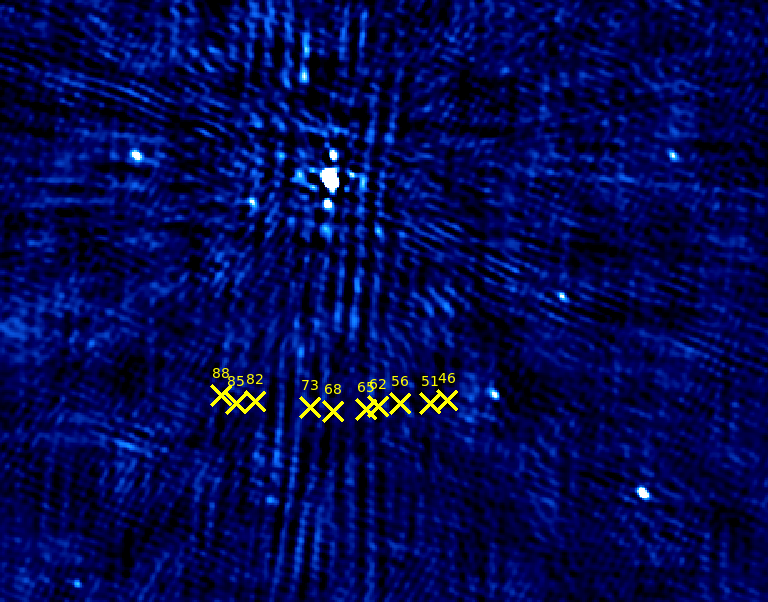

It is possible to filter these out of your false positives using a method developed for the AARTFAAC whole sky imager and outlined in the filtering stategies in [Kuiack et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.2966K/abstract). 
> "We found that excluding new source detections that occur within a space–time distance of 2.5° angular separation and 500 s was adequate to reject moving sources; these parameters were tuned using a sample data set which contained a number of transiting unidentified flying objects."

Sadly, with the advent of satellite constellations that are emitting or reflecting radiation (for LOFAR and Starlink see e.g. [Di Vruno et al.](https://ui.adsabs.harvard.edu/abs/2023A%26A...676A..75D/abstract)) and filters like this will likely become more important.

The following code is based upon the filtering strategy developed by Kuiack and his code is available here on [GitHub](https://github.com/mkuiack/scratchpad/blob/2664e6812f16003e4947839d7de8a9d474e8cbc4/scripts/StreamingHarvest.py#L532-L538)

In [ ]:
# Loop through all the remaining candidates and remove sources associated in space (<2.5 deg) and time (<500 sec)
rejected_runcats=[]

for index, row in NewSrcDataFrame.iterrows():
    c1 = row.SkyCoord
    for index2, row2 in NewSrcDataFrame.iterrows():
        if index2 > index:
            c2 = row2.SkyCoord
            if (c1.separation(c2).deg < 2.5) and ((row2.TimeDetect-row.TimeDetect).total_seconds() < 600):
                rejected_runcats.append(row.RuncatID)
                rejected_runcats.append(row2.RuncatID)

rejected_runcats = np.unique(rejected_runcats)
rejected_runcats



In [ ]:
NewSrcDataFrame = NewSrcDataFrame[~NewSrcDataFrame['RuncatID'].isin(rejected_runcats)]
NewSrcDataFrame = NewSrcDataFrame.sort_values(by='detSigma', ascending=False)
NewSrcDataFrame

#### Visual Inspection

The goal is to filter as many noise artefacts as possible before reaching this stage. But, visual inspection is often required before confirming a source is transient. Here we plot the light curve and the detection image, in the same way as we did for the variable source candidates.

In [ ]:
images2 = session.query(Image).filter(Image.dataset_id == dataset_id).all()
images2 = pd.DataFrame(data=[[images[x].url,images[x].taustart_ts,np.around(images[x].band.freq_central/1e9, decimals=3)] for x in range(len(images))], columns=['Image','Time','Freq'])

for index, row in NewSrcDataFrame.iterrows():
    sourceID = row.RuncatID
    flxVals = session.query(Assocxtrsource,Extractedsource).select_from(join(Assocxtrsource,Extractedsource)).filter(Assocxtrsource.runcat_id == sourceID).all()
    lightcurve = pd.DataFrame(data=[[flxVals[x].Extractedsource.image.url, flxVals[x].Extractedsource.f_int, flxVals[x].Extractedsource.f_int_err, flxVals[x].Extractedsource.det_sigma, flxVals[x].Extractedsource.extract_type] for x in range(len(flxVals))], columns = ['Image','Flux','FluxErr','SNR','type'])
    lightcurve = pd.merge(lightcurve, images2, on="Image")

    print('Runcat = '+str(sourceID))
    print('RA: '+str(row.ra)+' Dec: '+str(row.dec))
    print('Image = '+row.detectImage)
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121)
    ax1.plot(lightcurve.Time,lightcurve.Flux, color='k')
    for index2, row2 in lightcurve.iterrows():
        if row2.type==0:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='o', markersize=7, linestyle='-',color='b')
        if row2.type==1:
            ax1.errorbar(row2.Time,row2.Flux, yerr=row2.FluxErr, fmt='v', markersize=7, linestyle='-',color='r')
    ax1.axhline(y=0.0, color='k', linestyle=':')
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_ylabel('Flux density (Jy)')
    ax1.set_xlabel('Time')

    maxFlux=0.0005
    
    extractedData, wcs = extract_data(row.detectImage,row.ra,row.dec,size)
    ax2 = fig.add_subplot(122, projection=wcs)
    fix_axes_limits_ax1(ax2,row.ra,row.dec, wcs,size)
    ax2.imshow(extractedData, origin='lower', cmap='gray_r', interpolation='nearest',vmin=0,vmax=maxFlux)
    ax2.scatter(row.ra,row.dec,transform=ax2.get_transform('fk5'),facecolor='none', edgecolor='r')
    ax2.coords[0].set_format_unit(u.deg)
    ax2.coords[1].set_format_unit(u.deg)
 
    ax2.set_xlabel('Right Ascension (deg)')
    ax2.set_ylabel('Declination (deg)')
    plt.show()


Associated with an extended source? Remove
Consistent with average lightcurve to 3sigma? Remove  